In [6]:
import cooler
import scipy.sparse as sp
import pandas as pd
import numpy as np
import sys

def coolload(filepath, resolution):
    if filepath.endswith("mcool"):
        filepath+=f"::/resolutions/{resolution}"
    cool = cooler.Cooler(filepath)
    print(f"loaded {filepath}")
    return cool

def chunkcooler(cooler,stepsize=5000000,chromosomes=['chr5']):
    assert isinstance(chromosomes,list)
    chunked_cooler = {key:{} for key in chromosomes}
    for i in range(len(cooler.chromnames)):
        if cooler.chromnames[i] not in chromosomes:
            continue
        print(f"chunking cooler's {cooler.chromnames[i]}")
        for j in range(0,(cooler.chromsizes[i]//stepsize)+1):
            end=(j+1)*stepsize

            if end>cooler.chromsizes[i]:
                end=cooler.chromsizes[i]

            print(f"--chunk @: [{cooler.chromnames[i]}:{j*stepsize}-{end}]",end="")
            chunked_cooler[cooler.chromnames[i]][j*stepsize] = cooler.matrix(balance=False, as_pixels=True, join=True).fetch(f"{cooler.chromnames[i]}:{j*stepsize}-{end}")
            print(f": DONE")

            
    return chunked_cooler
        
def sparsematrixfromchunk(chunkdictionary,chromosomes=['chr5'],resolution=1000, stepsize=5000000):
    assert isinstance(chromosomes,list)
    sparse_chrom_dict = {}
    for chromosome_key in chromosomes:
        sparse_chrom_dict[chromosome_key]={}
        indices = chunkdictionary[chromosome_key].keys()
        print(f"converting {chromosome_key} chunks to scipy.sparse matrices:")
        for key in indices:
            print(f"--sparsed @: [{chromosome_key}:{key}]", end ="")
            mat_receiver = chunkdictionary[chromosome_key][key]
            if mat_receiver.empty:
                print(" size is empty: SKIP")
                continue
            dim1=min(key,min(mat_receiver['start1'].ravel()),min(mat_receiver['start2'].ravel()))
            dim2=max(max(mat_receiver['start1'].ravel()),max(mat_receiver['start2'].ravel()))

            start,end=0,dim2//resolution-dim1//resolution
            c1=[]
            c2=[]
            for index, row in mat_receiver.iterrows():
                c1+=[(int(row["start1"])-dim1)//resolution]
                c2+=[(int(row["start2"])-dim1)//resolution]

            data=mat_receiver[:]["count"]
            
            #shape of sparse should be the same until we hit the last matrix chunk...
            if key == list(indices)[-1]:
                shape_of_sparse = max(max(c1),max(c2))+1
            else:
                shape_of_sparse = stepsize//resolution

            print(f" size is {shape_of_sparse}", end="")
            _mat_receiver = sp.coo_matrix((data, (c1,c2)), shape=(shape_of_sparse,shape_of_sparse),dtype=np.float32)
            sparse_chrom_dict[chromosome_key][key] = _mat_receiver.tocsr()
            print(f": DONE")

    return sparse_chrom_dict



In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Path 
from matplotlib.ticker import EngFormatter

import cooltools
from cooltools.lib import plotting

import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['font.size'] = 10
%matplotlib inline
# this one to enable editing text in illustrator - from stackoverflow
mpl.rcParams['pdf.fonttype'] = 42

def pcolormesh_45deg(ax, matrix_c, start=0, resolution=1, *args, **kwargs):
    """heatmap tilted at 45 degree angle ...
    FROM:
    https://github.com/open2c/open2c_vignettes/blob/main/cooltools_manuscript/Figure_dots_n_pileups.ipynb
    """
    start_pos_vector = [start+resolution*i for i in range(len(matrix_c)+1)]
    import itertools
    n = matrix_c.shape[0]
    t = np.array([[1, 0.5], [-1, 0.5]])
    matrix_a = np.dot(np.array([(i[1], i[0])
                                for i in itertools.product(start_pos_vector[::-1],
                                                           start_pos_vector)]), t)
    x = matrix_a[:, 1].reshape(n + 1, n + 1)
    y = matrix_a[:, 0].reshape(n + 1, n + 1)
    im = ax.pcolormesh(x, y, np.flipud(matrix_c), cmap=fall_hm, *args, **kwargs)
    ax.set_ylim(0,max(np.max(x),np.max(y)))
    im.set_rasterized(True)
    return im


# helper functions for plotting
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True, formatter=bp_formatter):
    """format ticks with genomic coordinates as human readable"""
    if y:
        if formatter is not None:
            ax.yaxis.set_major_formatter(formatter)
    if x:
        if formatter is not None:
            ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

# had to redefine get_cmap from plotting because it was broken ...
def get_cmap(name):
    is_reversed = name.endswith("_r")
    try:
        if is_reversed:
            pal = plotting.PALETTES[name[:-2]][::-1]
        else:
            pal = plotting.PALETTES[name]
    except KeyError:
        raise ValueError('Palette not found "{}"'.format(name))
    return plotting.list_to_colormap(pal, name)

fall_hm = get_cmap("fall")



obs_norm = LogNorm(vmin=0.3, vmax=60)
ooe_norm = Normalize(vmin=-1.5, vmax=1.5)

# obs heatmap kwargs
obs_kwargs = dict(
#     cmap='fall', #cmap='fall'
    norm=obs_norm,
)
# ooe heatmap kwargs
ooe_kwargs = dict(
    cmap='fall',
    norm=ooe_norm,
)
# colorbar kwargs
colorbar_kwargs = dict(fraction=0.046, label='corrected frequencies')



def plain_rectangles45_around_dots(
    dots_df,
    window_size=50_000,
    lw=0.5,
    ec="darkgreen",
    fc="none",
    alpha=0.4,):
    """
    #yield a series of rectangles around called dots
    #works on 45-deg tilted heatmaps with 0.5 aspect ratio
    """
    path_kwargs = dict(lw=lw, ec=ec, fc=fc, alpha=alpha)
    s1, s2, e1, e2 = dots_df

    
    verts = [
        (s1 + abs(s1-e1)//2,abs(s1-e1)),
        (s1 + abs(s1-e2)//2,abs(s1-e2)),
        (s2 + abs(s2-e2)//2,abs(s2-e2)),
        (s2 + abs(s2-e1)//2,abs(s2-e1)),
        (s1 + abs(s1-e1)//2,abs(s1-e1)),
    ]
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    path = Path(verts, codes)
    return patches.PathPatch(path, **path_kwargs)


def scan(filein,low,high,chromosome, masterlist):
    with open(filein) as f:
        ctr = 0
        f.readline()
        for line in f:
            c0,c1,c2,_,c4,c5,c6 = line.split()
            c1=int(c1)
            c2=int(c2)
            c4=int(c4)
            c5=int(c5)
            if c0==chromosome:
                if (low <= c1 and c2 <= high) and (low<=c4 and c5<=high):
                    ctr+=1
                    masterlist += [[c1,c2,c4,c5]]
    if ctr:
        return masterlist



from mpl_toolkits.axes_grid1 import make_axes_locatable

def chr_color_plot(spmat,chromosome,key,starter,ender,Res):
    
    start=starter
    interval=abs(ender-starter)*Res

    matplotlib.rcParams['figure.dpi'] = 400
    matplotlib.rc('figure', figsize=(8,6))

    f, axd = plt.subplot_mosaic([["up"]],
                                constrained_layout=True,
                                gridspec_kw={'height_ratios': [6], 'width_ratios': [8], 'hspace':0, 'wspace':0})
#     divider = make_axes_locatable(axd)
#     cax = divider.append_axes('right', size='5%', pad=0.05)


    im = pcolormesh_45deg(
        axd["up"],
        spmat[f"chr{chromosome}"][key][starter:ender,starter:ender].todense(),
        start=0,
        resolution=1,
        **obs_kwargs,
    )
    

#     pcm = axd['up'].imshow(chrX[key][starter:ender,starter:ender].todense())
#     cax = f.colorbar(pcm, ax=axd['up'])   

    # colorbar:
    divider = make_axes_locatable(axd["up"])
    cax = divider.append_axes("right", size="3%", pad=0.1, aspect=6)
    cb = plt.colorbar(im, cax=cax,ticks=[0.5,7])
    cb.ax.set_yticklabels(['0.5','7'])
    
#     plt.clim(-1,1)

    
    axd["up"].set_title(f"Chr{chromosome}: {key+starter*Res}-{key+ender*Res}  HiC @ {Res}nt res")
    xticks = np.arange(key+starter*Res, key+ender*Res+1, (ender-starter)*Res//8)
    axd['up'].set_xticklabels(xticks)
    axd['up'].set_yticklabels(xticks)


In [8]:
rect_kwargs = dict(
    lw=1,
    ec="grey",
    fc="none",
    alpha=1,
)
    
fall_hm = get_cmap("fall")


In [5]:
# filepath = "/nfs/turbo/umms-drjieliu/proj/4dn/data/microC/hESC/raw/H1-hESC_200bp.cool"
# filepath="/nfs/turbo/umms-drjieliu/proj/4dn/data/bulkHiC/GM12878/4DNFIXP4QG5B.mcool"
# filepath="/nfs/turbo/umms-drjieliu/proj/4dn/data/microC/hESC/raw/4DNFI9GMP2J8.mcool"
# filepath="/nfs/turbo/umms-drjieliu/proj/Quagga/data/H1_Hi-C_alternates/4DNFI82R42AD.mcool"
# filepath="/nfs/turbo/umms-drjieliu/proj/4dn/data/RegionCaptureMicroC/updated_mcools_011424/GM12878_merged_011424.50.mcool"
# filepath="/nfs/turbo/umms-drjieliu/proj/4dn/data/RegionCaptureMicroC/mESC/raw/RCMC_WT_mm39.merged.50.mcool"

c_resolution = 5000
c_stepsize = 15000000
chrLOAD = ['chr1','chr3','chr5','chr8','chr16','chr18','chr19']#, 'chr13']
c = coolload(filepath,5000)

coolerdict = chunkcooler(c,stepsize=c_stepsize,chromosomes=chrLOAD)

# RC = c.matrix(balance=False,as_pixels=True,join=True).fetch("chr13")


-rw-r--r--. 1 fanfeng users 222M Apr 19  2023 /nfs/turbo/umms-drjieliu/proj/4dn/data/RegionCaptureMicroC/mESC/raw/RCMC_WT_mm39.merged.50.mcool


In [9]:
#simplify cooler file for use with matplotlib, take one resolution

filepath="/nfs/turbo/umms-drjieliu/proj/Quagga/data/H1_Hi-C_alternates/4DNFI82R42AD.mcool"
c = coolload(filepath,5000)


loaded /nfs/turbo/umms-drjieliu/proj/Quagga/data/H1_Hi-C_alternates/4DNFI82R42AD.mcool::/resolutions/5000


In [11]:
# change cooler into stepped matrices along main diagonal.

c_stepsize = 15000000
chrLOAD = ['chr7']

coolerdict = chunkcooler(c,stepsize=c_stepsize,chromosomes=chrLOAD)
"""
function:
    chunkcooler()    using a "step size," systematically use cooler's cooler.matrix() procedure to call\
                         a series of matrices sliding along the main diagonal. 
inputs:
                    
outputs:
    coolerdict:      Doubled dictionary of chromosomes and then matrices by step-size
    
    c_stepsize:      What step to fill the matrix chunks (i.e. 15000000 creates a set of 15Mb x 15Mb matrices).\
                         The final matrix less than this stepsize is made into the remainder length.
                         
    chrLOAD:         What chromosomes to load, defaults to try all. Not all mcool files have every
                         every chromosome and sometimes explicit declaration is required.
    
"""


chunking cooler's chr7
--chunk @: [chr7:0-15000000]

/tmp/ipykernel_84935/800051403.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for j in range(0,(cooler.chromsizes[i]//stepsize)+1):
/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:15000000-30000000]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:30000000-45000000]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:45000000-60000000]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:60000000-75000000]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:75000000-90000000]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:90000000-105000000]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:105000000-120000000]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:120000000-135000000]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:135000000-150000000]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:


: DONE
--chunk @: [chr7:150000000-159345973]

/tmp/ipykernel_84935/800051403.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if end>cooler.chromsizes[i]:
/tmp/ipykernel_84935/800051403.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end=cooler.chromsizes[i]


: DONE


In [12]:
# Convert chunked matrices into sparse matrices.

c_resolution = 5000
c_stepsize = 15000000
chrLOAD = ['chr7']

# !!! slow !!!
chunked_mat = sparsematrixfromchunk(coolerdict, chrLOAD, c_resolution, c_stepsize)
"""
function:
    sparsematrixfromchunk()
                        Taking the output of chunkcooler(), form these into sparsematrices to allow rapid\
                            drawing and redrawing of the matrices for checking of diagnostic stripes.
inputs:
    coolerdict:      Output of chunkcooler, a dictionary of chromosomes and then matrices by step-size.
    chrLOAD:         What chromosomes to load, defaults to try all. Not all mcool files have every
                         every chromosome and sometimes explicit declaration is required.
    c_resolution:
    c_stepsize:
                         
outputs:
    chunked_mat:     

chunked_mat = sparsematrixfromchunk(coolerdict, chrLOAD, c_resolution, c_stepsize)

"""



converting chr7 chunks to scipy.sparse matrices:
--sparsed @: [chr7:0] size is 3000: DONE
--sparsed @: [chr7:15000000] size is 3000: DONE
--sparsed @: [chr7:30000000] size is 3000: DONE
--sparsed @: [chr7:45000000] size is 3000: DONE
--sparsed @: [chr7:60000000] size is 3000: DONE
--sparsed @: [chr7:75000000] size is 3000: DONE
--sparsed @: [chr7:90000000] size is 3000: DONE
--sparsed @: [chr7:105000000] size is 3000: DONE
--sparsed @: [chr7:120000000] size is 3000: DONE
--sparsed @: [chr7:135000000] size is 3000: DONE
--sparsed @: [chr7:150000000] size is 1868: DONE


'\nfunction:\n    sparsematrixfromchunk()\n                        Taking the output of chunkcooler(), form these into sparsematrices to allow rapid                            drawing and redrawing of the matrices for checking of diagnostic stripes.\ninputs:\n    coolerdict:      Output of chunkcooler, a dictionary of chromosomes and then matrices by step-size.\n    chrLOAD:         What chromosomes to load, defaults to try all. Not all mcool files have every\n                         every chromosome and sometimes explicit declaration is required.\n    c_resolution:\n    c_stepsize:\n                         \noutputs:\n    chunked_mat:     \n\nchunked_mat = sparsematrixfromchunk(coolerdict, chrLOAD, c_resolution, c_stepsize)\n\n'

In [13]:

import pickle

# if we made sparse matrices already, we load it. 

# with open(r"./5KB_H1_HiC_Chr7_flt_SparseChunked.pickle", "rb") as output_file:
#     chunked_mat= pickle.load(output_file)



# otherwise, save it.

with open(r"./5KB_H1_HiC_Chr7_flt_SparseChunked.pickle", "wb") as output_file:
    pickle.dump(chunked_mat, output_file)

In [14]:
# for visualization

from os import listdir
from os.path import isfile, join

def gen_fig_part(axd,increment,position,chromo,key,starter,ender,mypath,files):
    
    """
    Function adapted from open2c
    
    INPUT:
        axd:            matplotlib axis object
        increment:      sample name, for surveying large numbers of files by integer
        position:       matplotlib axis name, i.e. axd["UP"]...
        chromo:         chromosome, must match formatting in stripe file
        key:            from chunked mat stepsize, the dictionary key such that chunkedmat[chromo][key]
        starter:        starting coordiante for visualization, value*resolution = exact
        ender:          ending coordinate for visualization window, value*resolution = exact
        mypath:         userpath to existing stripe files
    
    """
    
    im = pcolormesh_45deg(
        axd[position],
        chunked_mat[f"chr{chromo}"][key][starter:ender,starter:ender].todense(),
        start=0,
        resolution=1,
        **obs_kwargs,
    )   

    SPATH = f"{mypath}/{files[increment]}"
    stripes = []
    scan(SPATH, LB, UP, f"chr{chromo}", stripes)
    stripes = np.array(stripes)
    for a,b,c,d in stripes:
        rect = plain_rectangles45_around_dots(((a-LB)//Res, (b-LB)//Res, (c-LB)//Res, (d-LB)//Res), window_size=1, **rect_kwargs)
        axd[position].add_patch(rect)

    axd[position].set_title(f"condensed_swatch_{increment}")
    xticks = np.arange(key+starter*Res, key+ender*Res+1, (ender-starter)*Res//6)
    axd[position].set_xticklabels(xticks,rotation=45)
    axd[position].set_yticklabels(xticks)

In [15]:
# example of setting up and running gen_fig_part()

mypath="/nfs/turbo/umms-drjieliu/usr/temp_smoran/Fan_StripeCaller/053124_streamlined_stripefiltering/H1_opt_others_2"
#path to all stripe files

files=[]
for f in listdir(mypath):
#     print(join(mypath, f))   #check paths are correct
    if isfile(join(mypath, f)) and f.endswith("__filteredhg38H1.txt"):  #change suffix as needed
        files+=[f]


In [16]:
# Enumerated files name up the file "increments," to narrow parameter and choose best "increments"

for i,n in enumerate(files):
    print(i,n)

0 5000nt_MR15000000_ML50000_MD7500000_MW50000_WS10_SG1RH0.3_NSTR5_CHR7__filteredhg38H1.txt
1 5000nt_MR15000000_ML50000_MD7500000_MW50000_WS7_SG1RH0.3_NSTR0_CHR7__filteredhg38H1.txt
2 5000nt_MR15000000_ML20000_MD5000000_MW50000_WS7_SG1RH0.1_NSTR5_CHR7__filteredhg38H1.txt
3 5000nt_MR15000000_ML20000_MD5000000_MW50000_WS10_SG1RH0.1_NSTR5_CHR7__filteredhg38H1.txt
4 5000nt_MR15000000_ML50000_MD5000000_MW50000_WS10_SG1RH0.3_NSTR5_CHR7__filteredhg38H1.txt
5 5000nt_MR15000000_ML20000_MD7500000_MW50000_WS10_SG1RH0.1_NSTR0_CHR7__filteredhg38H1.txt
6 5000nt_MR15000000_ML50000_MD7500000_MW50000_WS10_SG1RH0.3_NSTR0_CHR7__filteredhg38H1.txt
7 5000nt_MR15000000_ML20000_MD7500000_MW50000_WS7_SG1RH0.1_NSTR0_CHR7__filteredhg38H1.txt
8 5000nt_MR15000000_ML50000_MD5000000_MW50000_WS7_SG1RH0.3_NSTR0_CHR7__filteredhg38H1.txt
9 5000nt_MR15000000_ML50000_MD5000000_MW50000_WS10_SG1RH0.1_NSTR0_CHR7__filteredhg38H1.txt
10 5000nt_MR15000000_ML50000_MD7500000_MW50000_WS7_SG1RH0.3_NSTR5_CHR7__filteredhg38H1.txt
11 

In [17]:
"""
Choosing a diagnostic region at Chromosome 7, ~115Mb-117.5Mb

that is, key = 105000000, or 105Mb.
lower bound (LB) is key + starter * resolution, or 115Mb
upper bound (UP) is key + ender * resolution or 117.5 Mb

"""

Res=c_resolution
chromo="7"
starter=2000
ender=2500
key=105000000
LB = starter*Res+key
UP = ender*Res+key

obs_norm = LogNorm(vmin=0.3, vmax=60)
ooe_norm = Normalize(vmin=-1.5, vmax=1.5)

# obs heatmap kwargs
obs_kwargs = dict(
#     cmap='fall', #cmap='fall'
    norm=obs_norm,
)

115000000 117500000


/tmp/ipykernel_84935/3567992967.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[position].set_xticklabels(xticks,rotation=45)
/tmp/ipykernel_84935/3567992967.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[position].set_yticklabels(xticks)


<Figure size 3900x2000 with 0 Axes>

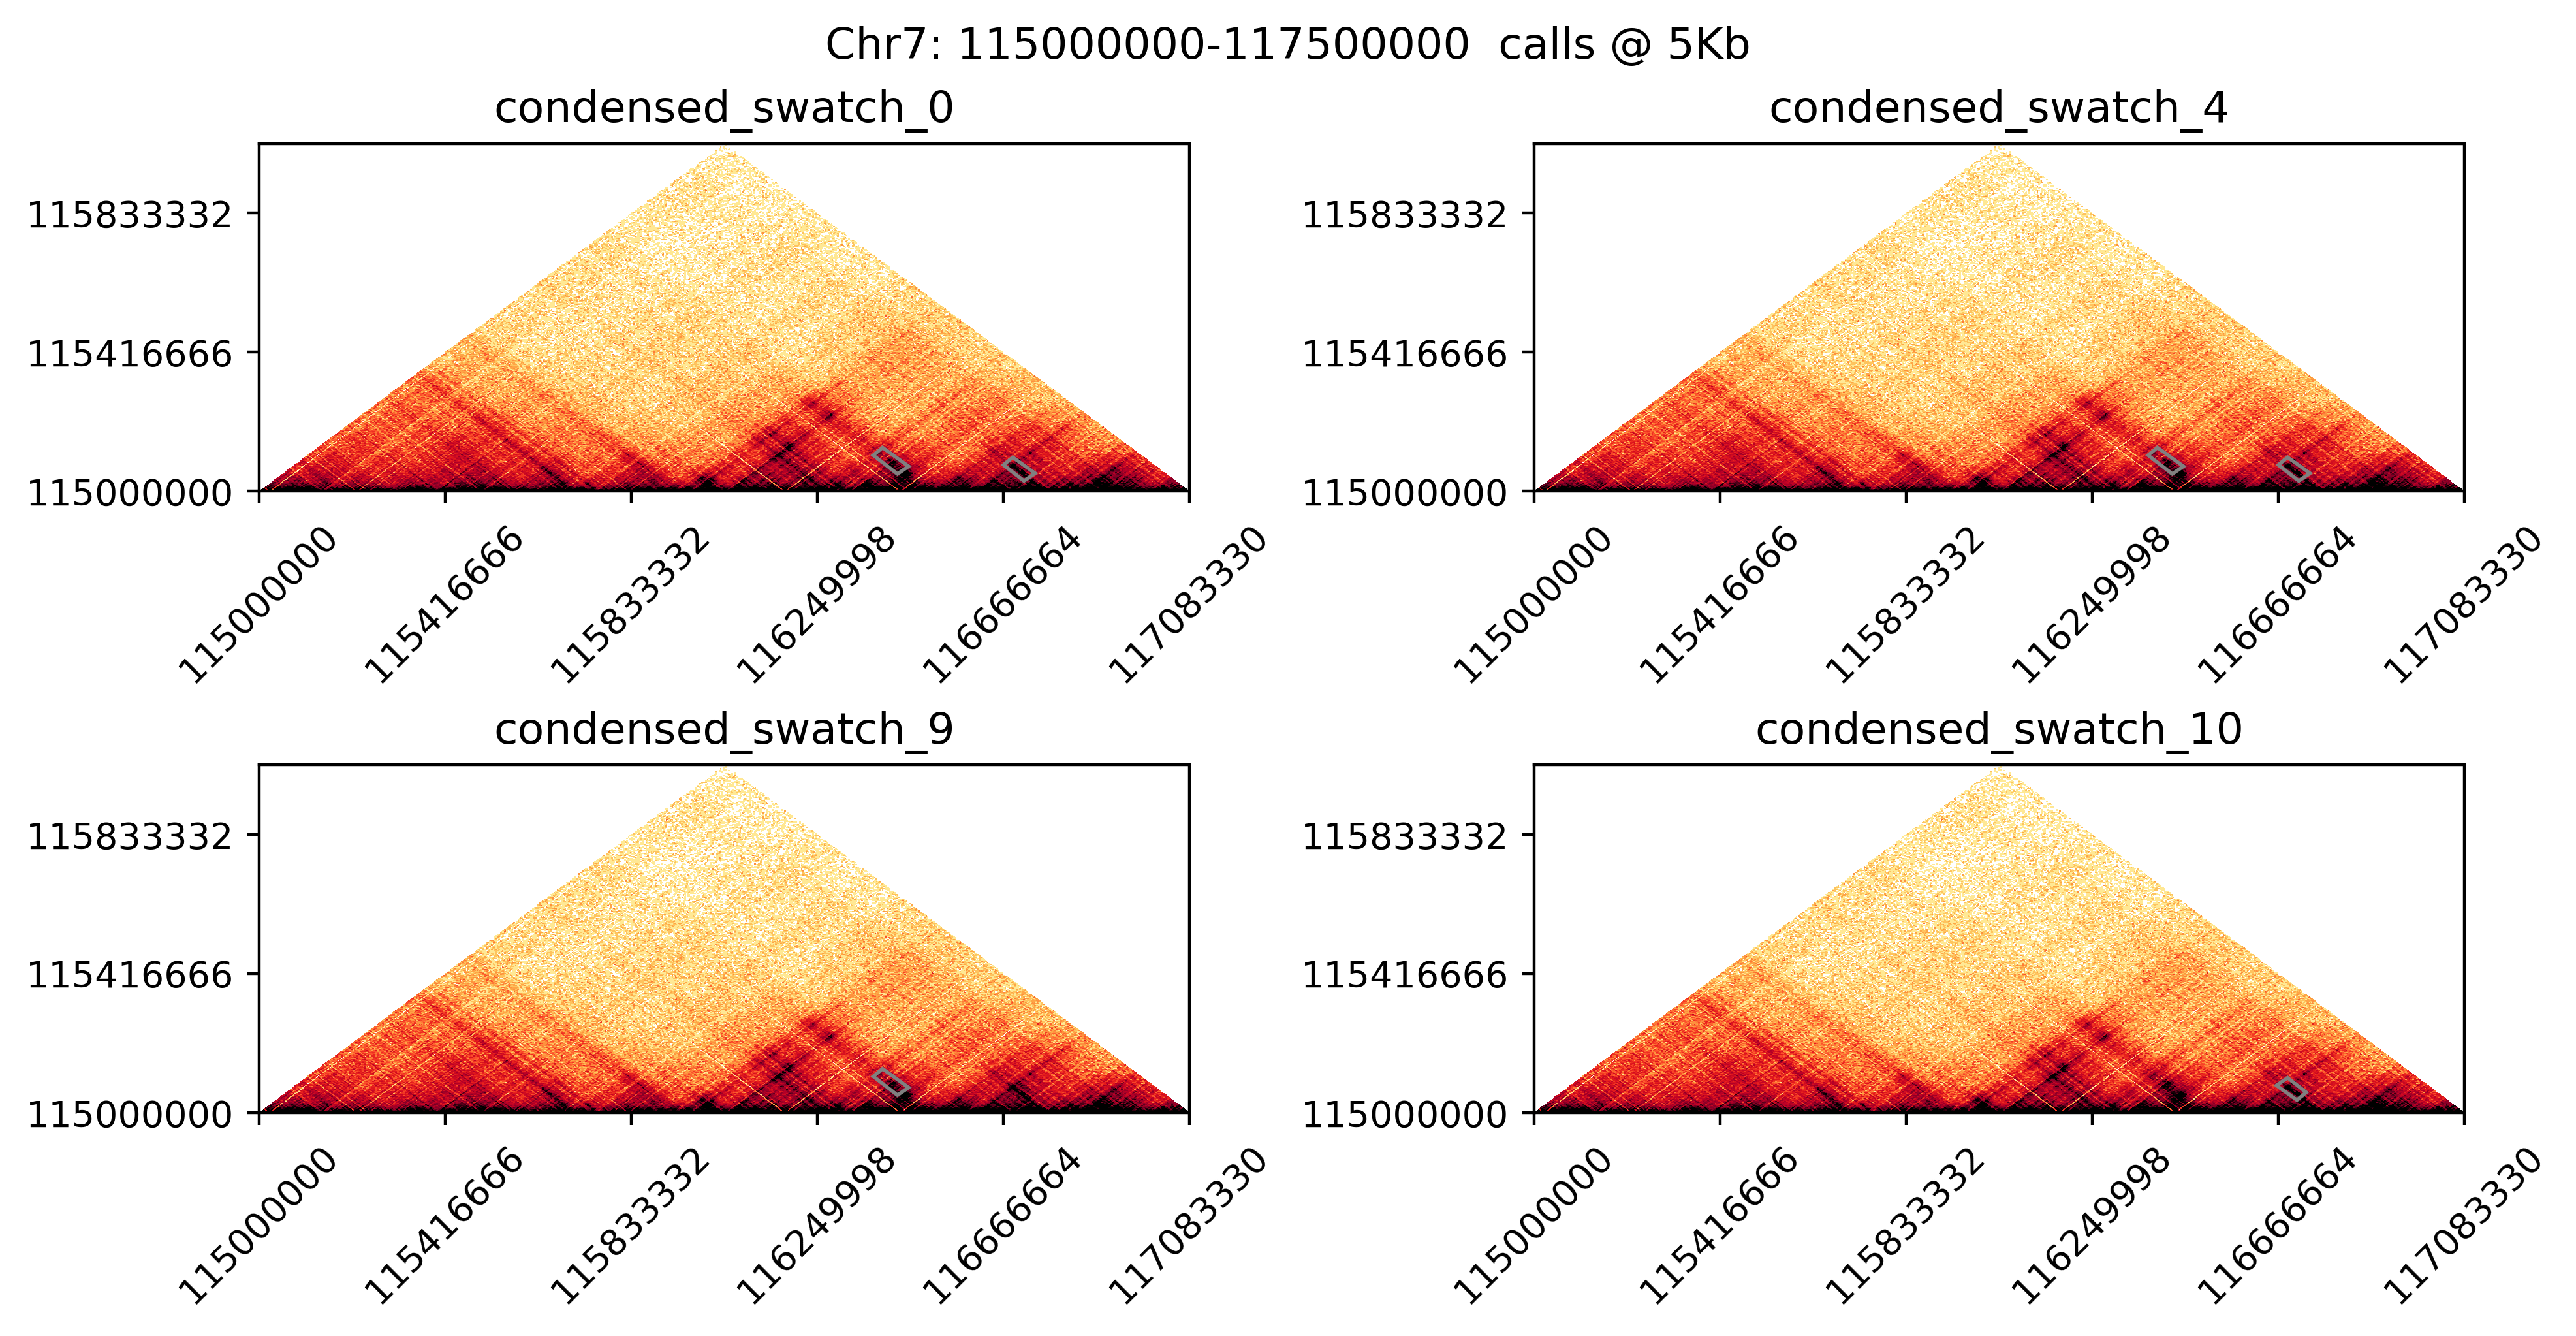

In [21]:

plt.clf()
print(LB,UP)
matplotlib.rcParams['figure.dpi'] = 400
matplotlib.rc('figure', figsize=(9.75,5))

f, axd = plt.subplot_mosaic([["UL","UR"],["BL","BR"]],
                            constrained_layout=True,)

f.suptitle(f"Chr{chromo}: {key+starter*Res}-{key+ender*Res}  calls @ 5Kb")

#file indices and position on subplot mosaic are zipped, zip([i,"position"]) for i reflecting enumerate(files) 
for incr,pos in zip([0,4,9,10],["UL","UR","BL","BR"]):
    gen_fig_part(axd, incr, pos,chromo,key,starter,ender,mypath,files) 
